In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# from sklearn import svm



## Glossary



- **HeartDisease**: Binary target variable


- **BMI**: Body Mass Index
- **SleepTime**: number of hours a person sleeps per day
- **PhysicalHealth**: number of days during the past 30 days in which the person reported poor physical health
- **MentalHealth**: number of days during the past 30 days in which the person reported poor mental health 


- **Smoking**: has the patient ever smoked more than 100 cigarettes in her entire life? 
- **AlcholDrining**: more than 14 drinks per week for men, more than 7 drinks per week for women
- **Stroke**: has the person ever had a stroke?
- **DiffWalking**: does the person experience difficulty walking?
- **Sex**: genre
- **AgeCategory**: age category (14 levels)
- **Race**: ethnicity 'White', 'Black', 'Asian', 'American Indian/Alaskan Native', 'Hispanic', 'Other'
- **Diabetic**: is the person diabetic?
- **PhysicalActivity**: is the person active?
- **GenHealth**: how is the general health condition of the person?
- **Asthma**: is the person affected by asthma?
- **KidneyDisease**: has the person suffered by kidney disease?
- **SkinCancer**: has the person suffered by skin cancer?


The dataset was found at https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease


In [2]:
df=pd.read_csv('data/heart_2020_cleaned.csv')
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


# Exploratory Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

The data are already cleaned. However, how it usually happens in case of "real" data, the dataset is highly imbalanced, as shown below. 

No     292422
Yes     27373
Name: HeartDisease, dtype: int64


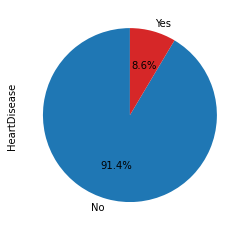

In [4]:
(df['HeartDisease']
 .value_counts()
 .plot
 .pie(autopct='%1.1f%%',
      startangle=90,
      colors=['tab:blue','tab:red']))

print(df['HeartDisease'].value_counts())

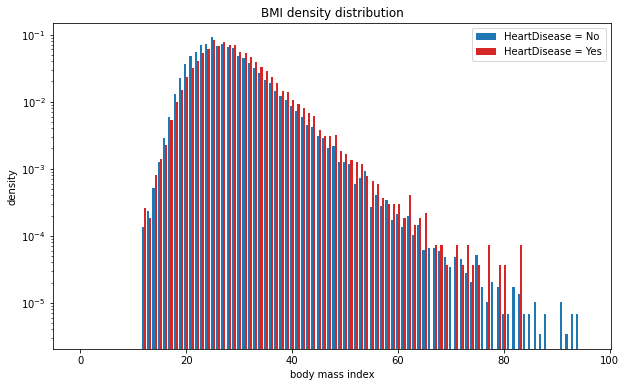

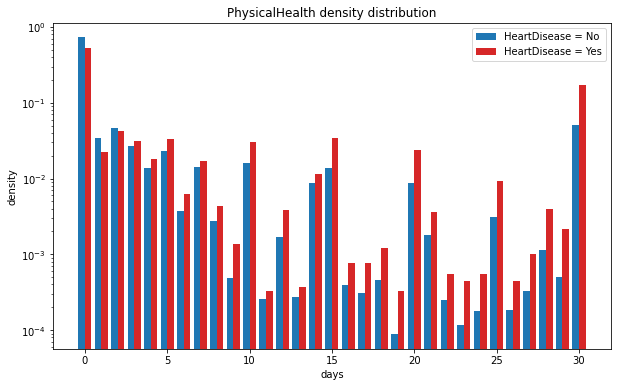

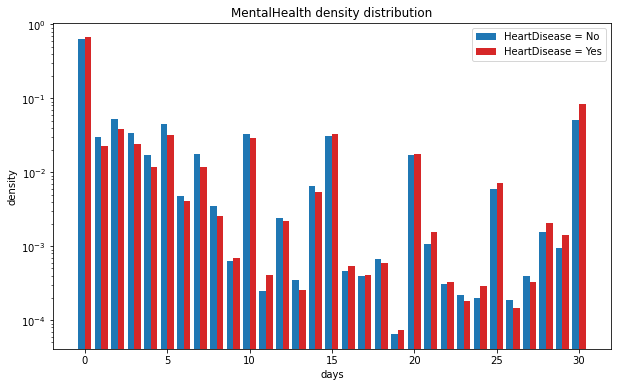

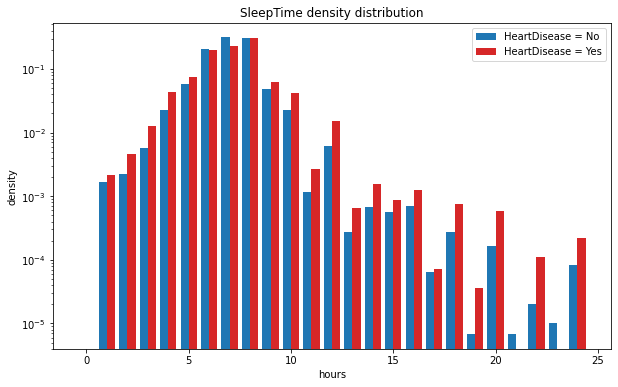

In [5]:
x_unit = ['body mass index', 'days', 'days', 'hours']

for unit, col_name in zip(x_unit, df.select_dtypes(include='float64').columns):    
    
    plt.figure(figsize=(10, 6))
    
    plt.hist([df[col_name].loc[df['HeartDisease'] == 'No'], df[col_name].loc[df['HeartDisease'] == 'Yes']],
             bins=range(0, np.ceil(df[col_name].max()).astype(int)+2, 1),
             density=True,
             log=True,
             align='left',
             label=['HeartDisease = No', 'HeartDisease = Yes'],
             color=['tab:blue', 'tab:red'])
    
    plt.title(f'{col_name} density distribution')
    plt.xlabel(unit)
    plt.ylabel('density')
    plt.legend()    
    plt.show()

A body mass index in the ~18 - 25 range indicates an ideal BMI. By looking at the BMI distribution one can notice how in that range the frequency of people who do not have heart disease is higher than the rest. 

In the tail of the distribution only data of people with no heart disease are found. This is most likely due to the high imbalance of the data and these outliers will be removed.


In [6]:
print('Max BMI for people with NO heartdisease:', df.loc[df['HeartDisease']=='No', 'BMI'].max())
print('Max BMI for people with heartdisease:', df.loc[df['HeartDisease']=='Yes', 'BMI'].max())


(df
 .loc[ df['BMI'] > (df.loc[df['HeartDisease'] == 'Yes','BMI'].max()), 'HeartDisease']
 .value_counts())

Max BMI for people with NO heartdisease: 94.85
Max BMI for people with heartdisease: 83.33


No    21
Name: HeartDisease, dtype: int64

In [7]:
df.groupby('HeartDisease').mean()

,BMI,PhysicalHealth,MentalHealth,SleepTime
HeartDisease,,,,
No,28.224658,2.956416,3.828778,7.093416
Yes,29.401592,7.808242,4.641764,7.136156


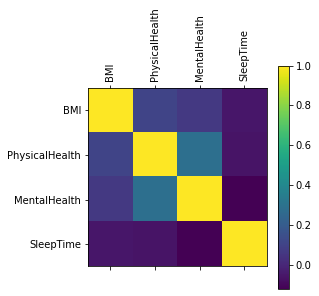

In [8]:
fl_var = df.select_dtypes(include='float64').columns
plt.matshow(df.select_dtypes(include='float64').corr())
plt.xticks(ticks=range(0, len(fl_var)), labels=fl_var, rotation='vertical')
plt.yticks(ticks=range(0, len(fl_var)), labels=fl_var)
plt.colorbar()
plt.show()

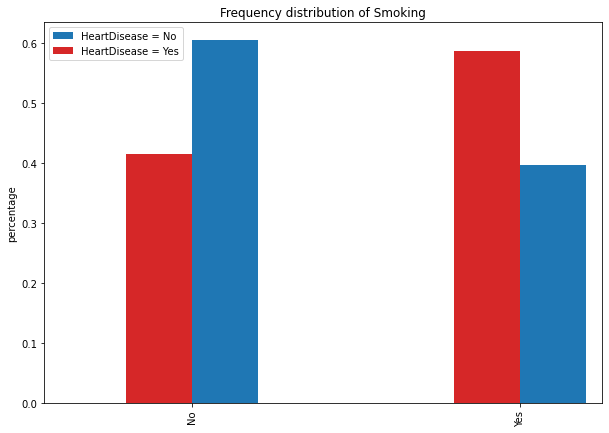

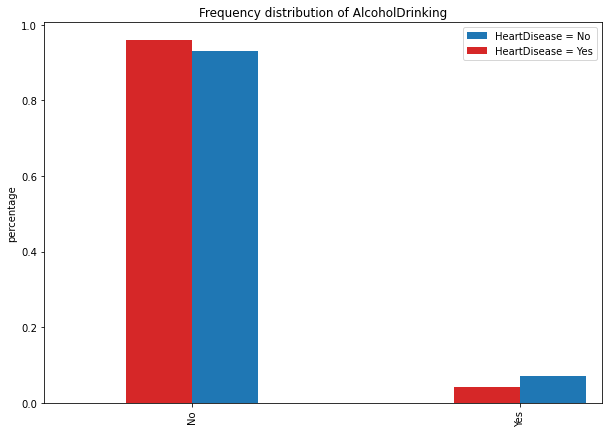

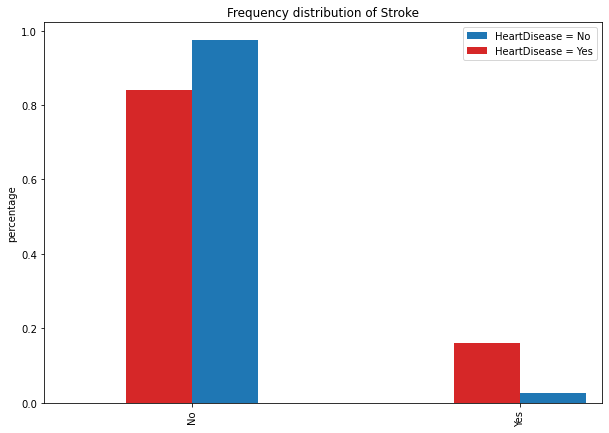

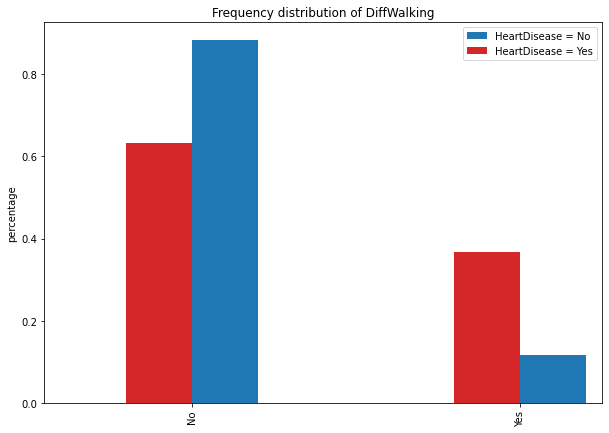

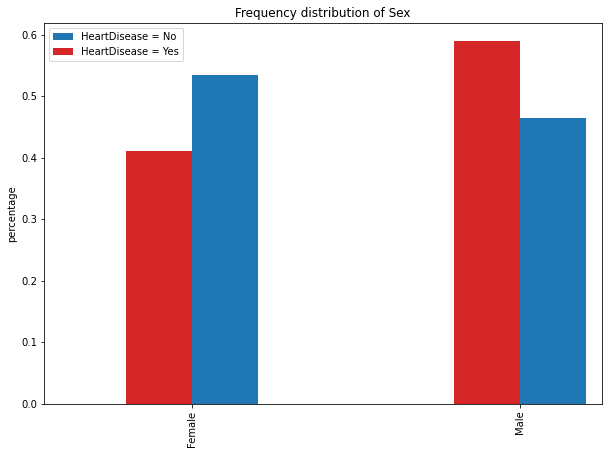

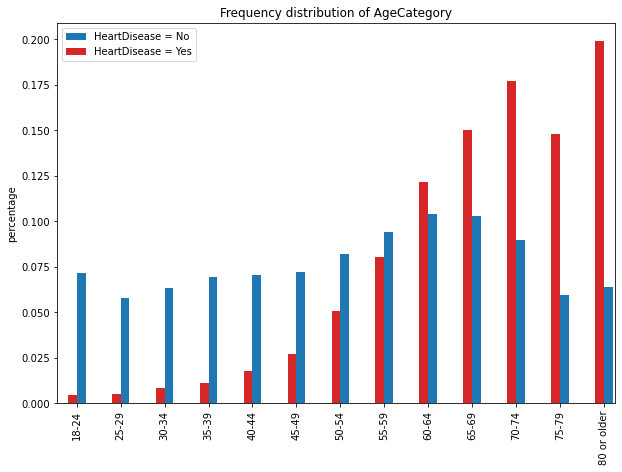

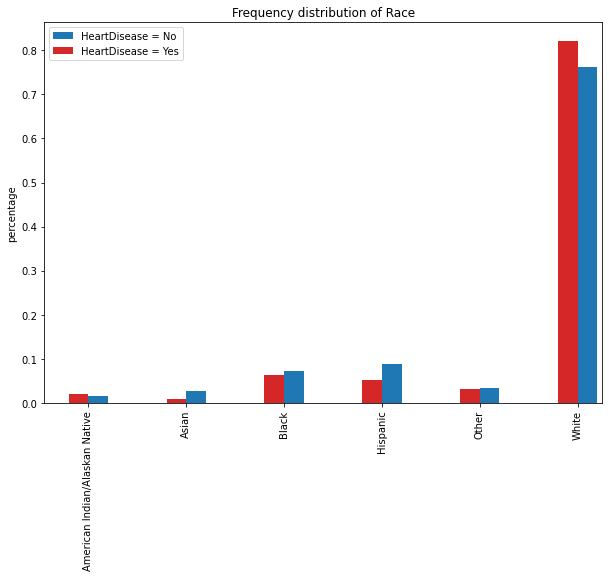

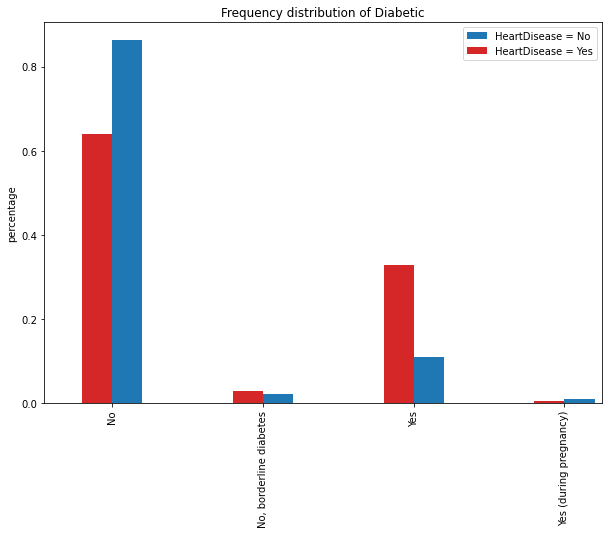

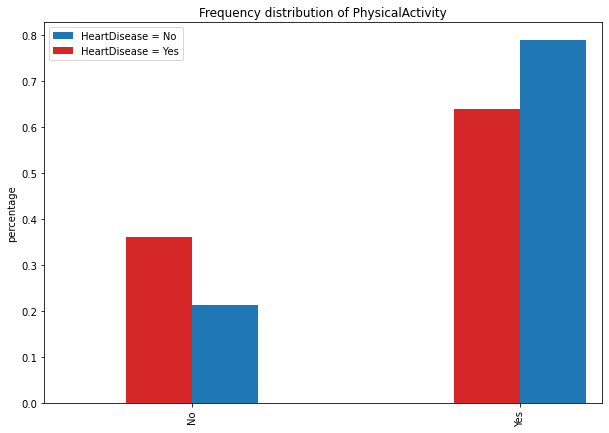

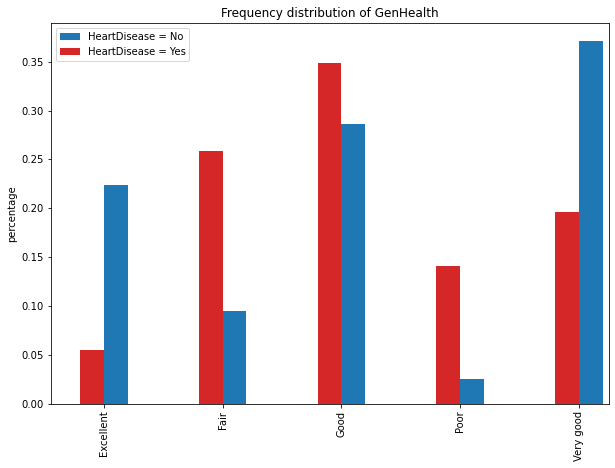

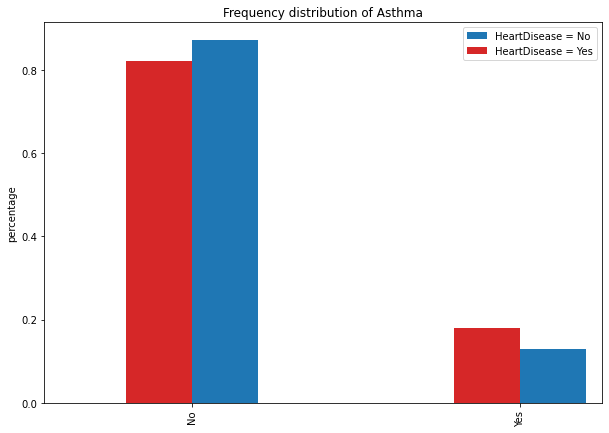

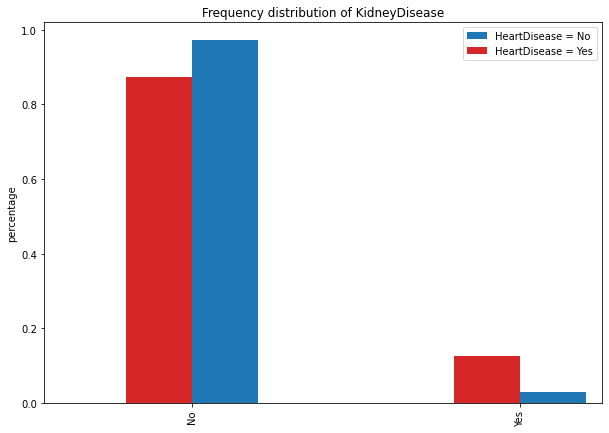

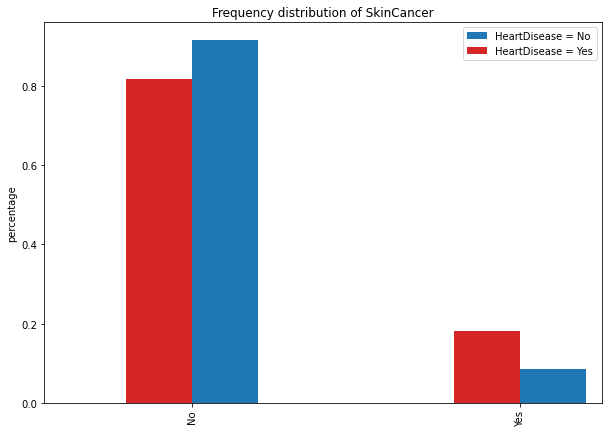

In [9]:
width = 0.2
fig_size = (10, 7)

for col in df.select_dtypes(include='object').columns[1:]:
    
    (df
     .loc[df['HeartDisease'] == 'No', col]
     .value_counts(normalize=True)
     .sort_index()
     .plot(kind='bar',
           color='tab:blue',
           figsize=fig_size,
           width=width,
           position=0,
#            title=f'Frequency distribution of {col}',
#            logy=True,
#            ylabel='percentage',
           label='HeartDisease = No')
     )
    
    (df
     .loc[df['HeartDisease'] == 'Yes', col]
     .value_counts(normalize=True)
     .sort_index()
     .plot(kind='bar',
           color='tab:red',
           figsize=fig_size,
           width=width,
           position=1,
           title=f'Frequency distribution of {col}',
#            logy=True,
           ylabel='percentage',
           label='HeartDisease = Yes')
     )
    
    plt.legend()
    plt.show()


From these distributions seem that age, in particular, plays a significant role in the presence of heart disease.

In [10]:
(df
 .pipe(pd.get_dummies,
        drop_first=True,
        columns=[i for i in df.columns 
                 if i != 'HeartDisease' and i != 'Sex' and (df[i].dtype != 'float64')])
 .groupby(['Sex', 'HeartDisease'])
 .mean())


BMI  PhysicalHealth  MentalHealth  SleepTime  \
Sex    HeartDisease                                                       
Female No            28.075363        3.289868      4.548294   7.121300   
       Yes           29.375993        9.135660      6.155866   7.080025   
Male   No            28.396724        2.572105      2.999522   7.061280   
       Yes           29.419411        6.884256      3.587831   7.175228   

                     Smoking_Yes  AlcoholDrinking_Yes  Stroke_Yes  \
Sex    HeartDisease                                                 
Female No               0.361810             0.069170    0.028204   
       Yes              0.523411             0.038099    0.179010   
Male   No               0.435933             0.072182    0.024026   
       Yes              0.629345             0.044179    0.147345   

                     DiffWalking_Yes  AgeCategory_25-29  AgeCategory_30-34  \
Sex    HeartDisease                                                          
Female No                   0.140333           0.050392           0.057680   
       Yes                  0.457006           0.005875           0.008813   
Male   No                   0.091350           0.065749           0.069900   
       Yes                  0.303241           0.004151           0.007869   

                     ...  Diabetic_Yes  Diabetic_Yes (during pregnancy)  \
Sex    HeartDisease  ...                                                  
Female No            ...      0.106731                         0.015654   
       Yes           ...      0.320011                         0.009614   
Male   No            ...      0.111401                         0.000000   
       Yes           ...      0.332239                         0.000000   

                     PhysicalActivity_Yes  GenHealth_Fair  GenHealth_Good  \
Sex    HeartDisease                                                         
Female No                        0.769504        0.102535        0.286241   
       Yes                       0.570767        0.289923        0.337013   
Male   No                        0.809608        0.084939        0.285268   
       Yes                       0.686350        0.237127        0.357643   

                     GenHealth_Poor  GenHealth_Very good  Asthma_Yes  \
Sex    HeartDisease                                                    
Female No                  0.028185             0.371161    0.150462   
       Yes                 0.162453             0.167260    0.240609   
Male   No                  0.022274             0.370730    0.105859   
       Yes                 0.125472             0.216990    0.138175   

                     KidneyDisease_Yes  SkinCancer_Yes  
Sex    HeartDisease                                     
Female No                     0.030836        0.085233  
       Yes                    0.144739        0.149368  
Male   No                     0.025734        0.084607  
       Yes                    0.113328        0.204598  

[4 rows x 36 columns]

# Data Preparation

In the following pipeline I start by making a copy of the initial dataset. In terms of performance this is not the best choice, however it helps to avoid side-effects in dataframes during the development, making it more efficient and clear.

In [11]:
def start_pipeline(dataf):
    return dataf.copy()

def prepare_dataset(dataf):
    dataf['HeartDisease'] = dataf['HeartDisease'].replace({'No': 0, 'Yes': 1})
    dataf = pd.get_dummies(dataf, drop_first=True)
    return dataf

def remove_outliers(dataf): 
    dataf = (dataf
             .drop(dataf
                   .loc[dataf['BMI'] > (dataf.loc[dataf['HeartDisease'] == 1, 'BMI'].max()), ].index,
                   axis=0))
    return dataf


df_clean = (df
            .pipe(start_pipeline)
            .pipe(prepare_dataset)
            .pipe(remove_outliers))

df_clean.head()

,HeartDisease,BMI,PhysicalHealth,MentalHealth,SleepTime,Smoking_Yes,AlcoholDrinking_Yes,Stroke_Yes,DiffWalking_Yes,Sex_Male,...,Diabetic_Yes,Diabetic_Yes (during pregnancy),PhysicalActivity_Yes,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,Asthma_Yes,KidneyDisease_Yes,SkinCancer_Yes
0,0,16.60,3.0,30.0,5.0,1,0,0,0,0,...,1,0,1,0,0,0,1,1,0,1
1,0,20.34,0.0,0.0,7.0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0
2,0,26.58,20.0,30.0,8.0,1,0,0,0,1,...,1,0,1,1,0,0,0,1,0,0
3,0,24.21,0.0,0.0,6.0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,0,23.71,28.0,0.0,8.0,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0


In [12]:
y = df_clean.loc[:, 'HeartDisease'].to_numpy()
X = df_clean.drop('HeartDisease', axis=1).to_numpy()

print(y.shape, X.shape)

(319774,) (319774, 37)


# Imbalanced data

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)
print(f'training data: {X_train.shape}, {y_train.shape}')
print(f'test data: {X_test.shape}, {y_test.shape}')

training data: (255819, 37), (255819,)
test data: (63955, 37), (63955,)


In [14]:
def plot_ROC_curve(y_test, y_pred_prob):
    
    fpr, tpr, th_ = roc_curve(y_test, y_pred_prob)    
    plt.plot(fpr, tpr, label=f'TPR vs FPR, AUC: {roc_auc_score(y_test, y_pred_prob):.2f}')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend()
    plt.show()

    
def plot_PrecRec_curve(y_test, y_pred_prob):
    
    pre, rec, th_ = precision_recall_curve(y_test, y_pred_prob)
    plt.plot(rec, pre, label='precision vs recall, HeartDisease = Yes')
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.legend()
    plt.show()


[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.3s
[Pipeline] ................ (step 2 of 2) Processing LR, total=   1.6s
              precision    recall  f1-score   support

           0       0.97      0.74      0.84     58513
           1       0.22      0.79      0.35      5442

    accuracy                           0.75     63955
   macro avg       0.60      0.76      0.60     63955
weighted avg       0.91      0.75      0.80     63955



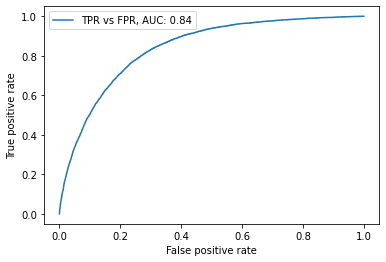

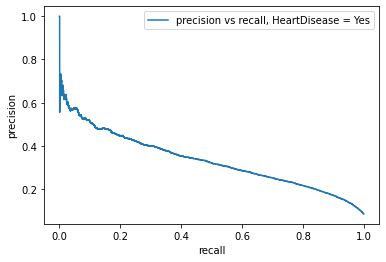

In [15]:
# max_iter = 600 in order to make the model converge
pipeline = Pipeline([('scaler', StandardScaler()),
                     ('LR', LogisticRegression(max_iter=600, class_weight='balanced'))],
                    verbose = True)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
plot_ROC_curve(y_test, y_pred_prob)
plot_PrecRec_curve(y_test, y_pred_prob)

# Undersampling

In [16]:
X_u, y_u = RandomUnderSampler(sampling_strategy='majority').fit_resample(X, y)
print(X_u.shape, y_u.shape)
np.unique(y_u, return_counts=True)

(54746, 37) (54746,)


(array([0, 1], dtype=int64), array([27373, 27373], dtype=int64))

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_u, y_u, test_size=0.2, random_state=2022)

print(f'training data: {X_train.shape}, {y_train.shape}')
print(f'test data: {X_test.shape}, {y_test.shape}')

#scaling the data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

training data: (43796, 37), (43796,)
test data: (10950, 37), (10950,)


The parameters of the models in the next cell are the results of a rough cross validation tuning. It was necessary to find , for example, a significant number for the "neighbors" parameter of the KNeighborsClassifier.


In [18]:
# LR_parameters = {'C': [0.001, 0.01, 0.1, 10, 15, 30, 50, 100]}
# KNC_parameters = {'n_neighbors': [55, 60, 65, 70, 75]}
# DCT_parameters = {'max_depth': [5, 7, 10, 15],
#                   'min_samples_leaf': range(1, 10, 2),
#                   'min_samples_split': range(2, 15, 2)}
# RFC_parameters = {'max_depth': [5, 7, 10, 15],
#                   'min_samples_leaf': range(1, 10, 2),
#                   'min_samples_split': range(2, 15, 2)}

# models = [
#     GridSearchCV(LogisticRegression(max_iter=1000), param_grid=LR_parameters, cv=5,),
#           GridSearchCV(KNeighborsClassifier(), param_grid=KNC_parameters, cv=5),
#           GridSearchCV(
#               DecisionTreeClassifier(criterion='entropy'), param_grid=DCT_parameters, cv=5, refit='roc_auc'),
#           GridSearchCV(
#               RandomForestClassifier(n_estimators=10, random_state=0), param_grid=RFC_parameters, cv=5, refit='roc_auc')]



models = [
          LogisticRegression(max_iter=1000, C=0.1),
          KNeighborsClassifier(n_neighbors=65),
          DecisionTreeClassifier(
              criterion='entropy', max_depth=10, min_samples_leaf=9, min_samples_split=2),
          RandomForestClassifier(
              n_estimators=40, max_depth=15, min_samples_leaf=3, min_samples_split=14, random_state=0)]


# dataframe used to compare the results
df_evaluation = pd.DataFrame()

In [19]:
def fit_evaluate(
    dataf,
    estimator,
    X_train,
    y_train,
    X_test,
    y_test
):
    
    """
    This function fits and evaluates an estimator that has the predict_proba() method.
    The obtained results are updated into dataf.
    """
    
    if hasattr(estimator, 'estimator'):
        print('\n', '#'*20, f'Model Evaluation: {estimator.estimator.__class__.__name__}', '#'*20, '\n')
    else:
        print('\n', '#'*20, f'Model Evaluation: {estimator.__class__.__name__}', '#'*20, '\n')
    
    tic = dt.datetime.now()
    estimator.fit(X_train, y_train)
    if hasattr(estimator, 'best_params_'):
        print(estimator.best_params_)
    toc = dt.datetime.now()
    fit_time=toc-tic
    dataf.loc[estimator.__class__.__name__, 'Fit Time [s]'] = fit_time.total_seconds()
    
    #training data
    y_pred_train = estimator.predict(X_train)
    y_pred_prob_train = estimator.predict_proba(X_train)[:, 1]
    
    dataf.loc[estimator.__class__.__name__, 'Train Accuracy'] = accuracy_score(y_train, y_pred_train)
    dataf.loc[estimator.__class__.__name__, 'Train AUC'] = roc_auc_score(y_train, y_pred_prob_train)
    print('*Training set:')
    print(classification_report(y_train, y_pred_train))
    
    #test data
    y_pred = estimator.predict(X_test)
    y_pred_prob = estimator.predict_proba(X_test)[:, 1]

    dataf.loc[estimator.__class__.__name__, 'Test Accuracy'] = accuracy_score(y_test, y_pred)
    dataf.loc[estimator.__class__.__name__, 'Test AUC'] = roc_auc_score(y_test, y_pred_prob)
    print('*Test set:')
    print(classification_report(y_test, y_pred))  
    
    #plot metrics
    plot_ROC_curve(y_test, y_pred_prob)
    plot_PrecRec_curve(y_test, y_pred_prob)
    
    return dataf




 #################### Model Evaluation: LogisticRegression #################### 

*Training set:
              precision    recall  f1-score   support

           0       0.77      0.75      0.76     21890
           1       0.76      0.78      0.77     21906

    accuracy                           0.77     43796
   macro avg       0.77      0.77      0.77     43796
weighted avg       0.77      0.77      0.77     43796

*Test set:
              precision    recall  f1-score   support

           0       0.77      0.74      0.76      5483
           1       0.75      0.78      0.76      5467

    accuracy                           0.76     10950
   macro avg       0.76      0.76      0.76     10950
weighted avg       0.76      0.76      0.76     10950



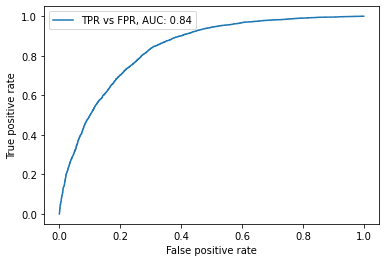

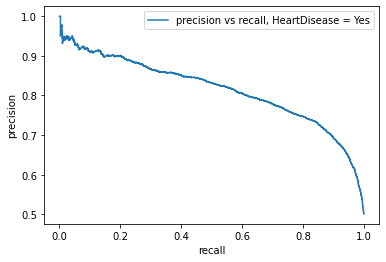


 #################### Model Evaluation: KNeighborsClassifier #################### 

*Training set:
              precision    recall  f1-score   support

           0       0.75      0.77      0.76     21890
           1       0.77      0.74      0.75     21906

    accuracy                           0.76     43796
   macro avg       0.76      0.76      0.76     43796
weighted avg       0.76      0.76      0.76     43796

*Test set:
              precision    recall  f1-score   support

           0       0.75      0.76      0.75      5483
           1       0.76      0.74      0.75      5467

    accuracy                           0.75     10950
   macro avg       0.75      0.75      0.75     10950
weighted avg       0.75      0.75      0.75     10950



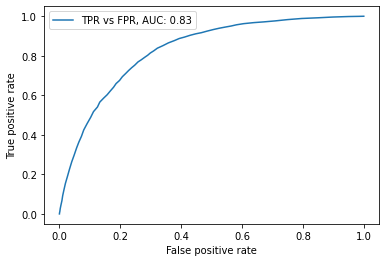

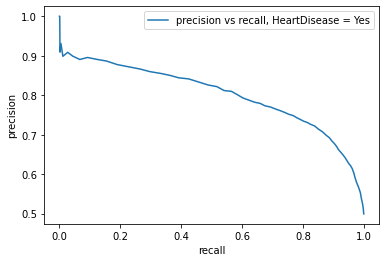


 #################### Model Evaluation: DecisionTreeClassifier #################### 

*Training set:
              precision    recall  f1-score   support

           0       0.77      0.75      0.76     21890
           1       0.76      0.78      0.77     21906

    accuracy                           0.76     43796
   macro avg       0.76      0.76      0.76     43796
weighted avg       0.76      0.76      0.76     43796

*Test set:
              precision    recall  f1-score   support

           0       0.75      0.72      0.74      5483
           1       0.73      0.76      0.75      5467

    accuracy                           0.74     10950
   macro avg       0.74      0.74      0.74     10950
weighted avg       0.74      0.74      0.74     10950



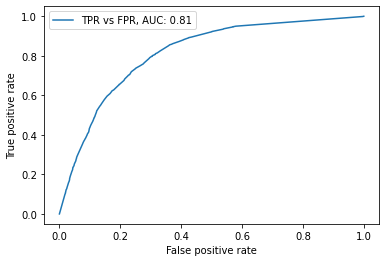

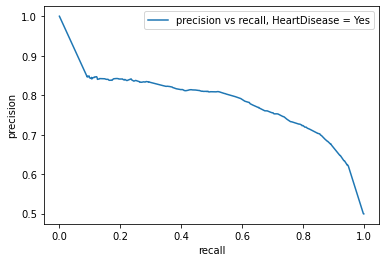


 #################### Model Evaluation: RandomForestClassifier #################### 

*Training set:
              precision    recall  f1-score   support

           0       0.80      0.77      0.79     21890
           1       0.78      0.81      0.79     21906

    accuracy                           0.79     43796
   macro avg       0.79      0.79      0.79     43796
weighted avg       0.79      0.79      0.79     43796

*Test set:
              precision    recall  f1-score   support

           0       0.78      0.74      0.76      5483
           1       0.75      0.79      0.77      5467

    accuracy                           0.76     10950
   macro avg       0.76      0.76      0.76     10950
weighted avg       0.76      0.76      0.76     10950



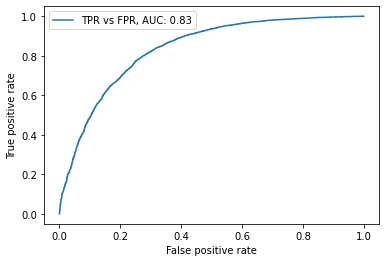

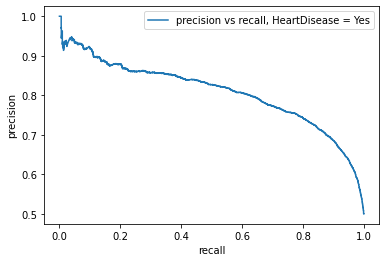

,Fit Time [s],Train Accuracy,Train AUC,Test Accuracy,Test AUC
LogisticRegression,0.205343,0.765298,0.840175,0.760913,0.839025
RandomForestClassifier,1.312244,0.789912,0.876999,0.761005,0.833445
KNeighborsClassifier,0.014776,0.757946,0.837135,0.751142,0.828715
DecisionTreeClassifier,0.195045,0.762353,0.838139,0.741735,0.812231


In [20]:
for model in models:
    (df_evaluation
     .pipe(fit_evaluate,
           estimator=model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test))

df_evaluation.sort_values(by=['Test AUC'], ascending=False)

Next steps

1- Feature Selection

2- Parameter Tuning


